# Predicción del Retraso de Vuelos
Yadier Betancourt Martínez

Marlín Ramírez Rodríguez

Para la realización de este trabajo estaremos usando la Base de casos Airlines Dataset to predict a delay, la cual puede ser accedida en Kaggle: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master("local[*]")\
        .appName("Airline Delay")\
        .getOrCreate()

Este conjunto de datos de aerolíneas contiene información sobre 539,383 vuelos. Cada vuelo está representado por 8 características diferentes que describen sus detalles.

A continuación se muestra un resumen de las características:

    Aerolínea: Nombre de la aerolínea que opera el vuelo (por ejemplo, "American Airlines", "Alaska Airlines").
    Vuelo: Identificador único del vuelo.
    Aeropuerto de Origen: Código IATA del aeropuerto de origen del vuelo.
    Aeropuerto de Destino: Código IATA del aeropuerto de destino del vuelo.
    Día de la Semana: Día de la semana en que se programó el vuelo.
    Tiempo tomado: Tiempo que tomó el vuelo.
    Largo: Distancia del vuelo.
    Retraso: si presentó retraso o no

In [2]:
path = r'C:\Estudio\programeo\IA\BigDataOpt\Airlines.csv'

df = spark.read.csv(path, header=True, inferSchema=True)

df.show(10)

+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  1|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|
|  2|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|
|  3|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|
|  4|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|
|  5|     AS|   108|        ANC|      SEA|        3|  30|   202|    0|
|  6|     CO|  1094|        LAX|      IAH|        3|  30|   181|    1|
|  7|     DL|  1768|        LAX|      MSP|        3|  30|   220|    0|
|  8|     DL|  2722|        PHX|      DTW|        3|  30|   228|    0|
|  9|     DL|  2606|        SFO|      MSP|        3|  35|   216|    1|
| 10|     AA|  2538|        LAS|      ORD|        3|  40|   200|    1|
+---+-------+------+-----------+---------+---------+----+------+-----+
only s

A continuación podemos observar el esquema de nuestros datos, mostrándose las columnas y sus tipos de datos, así como la cantidad de casos de nuestro dataset:

In [3]:
df.printSchema()
df.count()

root
 |-- id: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Flight: integer (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Length: integer (nullable = true)
 |-- Delay: integer (nullable = true)



539383

El siguiente fragmento de código nos permite analizar cuántos vuelos opera cada aerolínea en el conjunto de datos. Se agrupa por aerolínea, se cuenta el número de vuelos para cada aerolínea, se ordena por número de vuelos de menor a mayor y finalmente se muestra el resultado:

In [4]:
df.groupBy('Airline').count().sort('count',ascending=True).show()

+-------+-----+
|Airline|count|
+-------+-----+
|     HA| 5578|
|     F9| 6456|
|     AS|11471|
|     OH|12630|
|     YV|13725|
|     B6|18112|
|     9E|20686|
|     FL|20827|
|     CO|21118|
|     UA|27619|
|     EV|27983|
|     XE|31126|
|     US|34500|
|     MQ|36605|
|     AA|45656|
|     OO|50254|
|     DL|60940|
|     WN|94097|
+-------+-----+



El siguiente fragmento de código nos permite analizar cuántos vuelos tienen cada valor de retraso en el conjunto de datos. Se agrupa por valor de retraso, se cuenta el número de vuelos con cada valor de retraso, se ordena por número de vuelos de mayor a menor y finalmente se muestra el resultado:

In [5]:
df.groupBy('Delay').count().sort('count',ascending=False).show()

+-----+------+
|Delay| count|
+-----+------+
|    0|299119|
|    1|240264|
+-----+------+



El siguiente fragmento de código es útil para obtener una comprensión rápida de las características básicas de las variables numéricas en un conjunto de datos, para ello describiremos el Length y el Time:

In [6]:
df.describe("Length","Time").show()

+-------+------------------+------------------+
|summary|            Length|              Time|
+-------+------------------+------------------+
|  count|            539383|            539383|
|   mean|132.20200673732765| 802.7289625368245|
| stddev| 70.11701559746582|278.04591081678984|
|    min|                 0|                10|
|    max|               655|              1439|
+-------+------------------+------------------+



El siguiente código nos permite analizar la relación entre el retraso del vuelo y la aerolínea. La tabla resultante mostrará cuántos vuelos de cada aerolínea experimentaron cada valor de retraso:

In [7]:
df.crosstab('Delay', 'Airline').sort('Delay_airline').show()

+-------------+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+
|Delay_Airline|   9E|   AA|  AS|  B6|   CO|   DL|   EV|  F9|   FL|  HA|   MQ|  OH|   OO|   UA|   US|   WN|   XE|   YV|
+-------------+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+
|            0|12460|27920|7579|9653| 9161|33488|16728|3557|14552|3792|23863|9128|27494|18673|22909|28440|19331|10391|
|            1| 8226|17736|3892|8459|11957|27452|11255|2899| 6275|1786|12742|3502|22760| 8946|11591|65657|11795| 3334|
+-------------+-----+-----+----+----+-----+-----+-----+----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+



El siguiente código nos permite analizar la relación entre el retraso del vuelo y el aeropuerto de origen. La tabla resultante mostrará cuántos vuelos de cada aeropuerto de origen experimentaron cada valor de retraso:

In [8]:
df.crosstab('Delay', 'AirportFrom').sort('Delay_AirportFrom').show()

+-----------------+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+----+---+---+---+----+---+---+---+---+---+---+---+---+---+---+----+---+----+---+---+---+---+---+---+---+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+----+---+----+----+---+---+---+---+---+---+---+---+---+----+---+---+---+----+---+---+----+-----+-----+---+---+---+---+----+---+---+---+---+---+----+---+---+---+---+----+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+---+---+---+----+----+---+---+---+----+---+---+---+---+---+---+---+----+----+---+---+---+---+----+----+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+----+---+---+---+---+---+----+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+---+---+----+----+----+----+---+---+-----+---+---+---+---+----+----+---+----+----+---+---+---+----+---+---+---+---+---+---+---+---+---+---+

El siguiente fragmento de código nos permite contar el número de vuelos que tomaron menos de 15 minutos:

In [9]:
df.filter(df.Time<=15).count()

93

El siguiente fragmento de código nos permite contar el número de vuelos que no se retrasaron:

In [10]:
df.filter(df.Delay==0).count()

299119

El siguiente fragmento de código nos permite calcular la duración promedio para cada vuelo en el conjunto de datos:

In [11]:
df.groupBy('Flight').agg({'Time':'mean'}).show()

+------+------------------+
|Flight|         avg(Time)|
+------+------------------+
|  6466|476.28169014084506|
|   463|  933.578947368421|
|  1580| 744.0990099009902|
|  6357|            781.94|
|  6397| 819.0555555555555|
|  3997| 540.6962025316456|
|   496| 739.8803418803419|
|  1591| 889.5211267605633|
|  6658| 984.9672131147541|
|  1829| 802.5547445255474|
|   471| 823.9830508474577|
|  1088|            732.61|
|  2366| 618.1884057971015|
|  2142| 806.9157894736842|
|   833|        649.921875|
|  2122| 671.1724137931035|
|  1959| 757.8048780487804|
|  5300|             505.0|
|  4519| 530.8771929824561|
|  1238| 820.5603448275862|
+------+------------------+
only showing top 20 rows



EL siguiente código elimina la columna id, pues no posee ninguna utilidad para nuestro trabajo:

In [12]:
df_new = df.drop('id')

El siguiente código crea una nueva columna llamada Length Scaled. La nueva columna contiene los valores de la columna original Length divididos por 655, siendo este número el máximo de Length, dato obtenido del `describe` visto anteriormente: 

In [13]:
df_new = df_new.withColumn('Length Scaled', df['Length'] / 655)
df_new.show()

+-------+------+-----------+---------+---------+----+------+-----+-------------------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|      Length Scaled|
+-------+------+-----------+---------+---------+----+------+-----+-------------------+
|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|0.31297709923664124|
|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|0.33893129770992364|
|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|0.25190839694656486|
|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|0.29770992366412213|
|     AS|   108|        ANC|      SEA|        3|  30|   202|    0| 0.3083969465648855|
|     CO|  1094|        LAX|      IAH|        3|  30|   181|    1|0.27633587786259545|
|     DL|  1768|        LAX|      MSP|        3|  30|   220|    0|0.33587786259541985|
|     DL|  2722|        PHX|      DTW|        3|  30|   228|    0| 0.3480916030534351|
|     DL|  2606|        SFO|      MSP|     

El siguiente fragmento de código agrupa por aerolínea y calcula el tiempo de duración promedio para cada aerolínea, mostrando ordenadamente las aerolíneas en las que los vuelos demoran más a las que menos: 

In [14]:
df_new.groupBy('Airline').agg({'Time':'mean'}).sort("avg(Time)", ascending=False).show()

+-------+-----------------+
|Airline|        avg(Time)|
+-------+-----------------+
|     FL|833.1544629567388|
|     YV|832.2568306010929|
|     B6|825.5022636925795|
|     OO|811.2070083973415|
|     F9|807.0885997521685|
|     US| 805.075884057971|
|     WN|802.3435922505499|
|     AA|800.8028955668477|
|     EV|799.8396526462495|
|     DL|799.6361667213653|
|     UA|797.7448857670445|
|     AS|796.6563507976637|
|     HA|795.2260666905701|
|     OH|793.0209817893904|
|     9E|792.1733056173257|
|     XE|792.1371843474908|
|     MQ|791.4752356235487|
|     CO|790.3554787385169|
+-------+-----------------+



El siguiente código analiza y visualiza a través de un gráfico de barras, la distribución de los vuelos por día de la semana en el conjunto de datos:

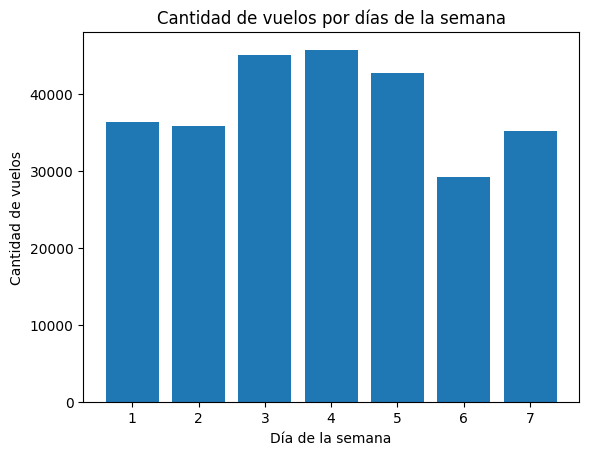

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

sample_df = df_new.sample(withReplacement=False, fraction=0.5, seed=42)
pandas_df = sample_df.toPandas()

delay_counts = pandas_df['DayOfWeek'].value_counts()

plt.bar(delay_counts.index, delay_counts.values)

plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de vuelos')
plt.title('Cantidad de vuelos por días de la semana')

plt.show()

El siguiente código analiza y visualiza a través de un gráfico de barras, la distribución de los vuelos por aerolínea en el conjunto de datos:

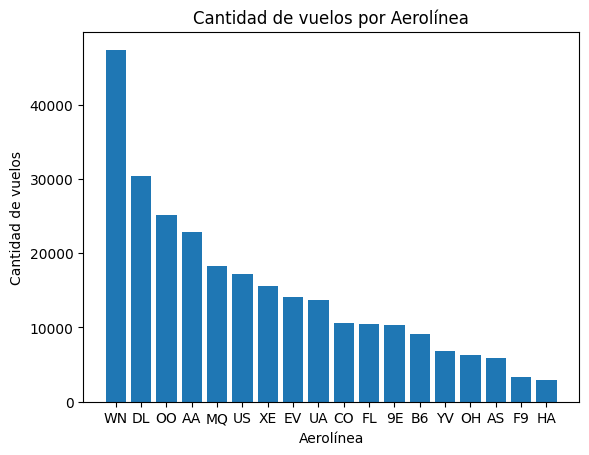

In [16]:
Airline_counts = pandas_df['Airline'].value_counts()

plt.bar(Airline_counts.index, Airline_counts.values)

# Agregar etiquetas y título
plt.xlabel('Aerolínea')
plt.ylabel('Cantidad de vuelos')
plt.title('Cantidad de vuelos por Aerolínea')

# Mostrar la gráfica
plt.show()

El siguiente código genera un diagrama de cajas para visualizar la distribución del tiempo de duración de los vuelos. El diagrama muestra la mediana, los cuartiles y los valores atípicos de la columna Time:

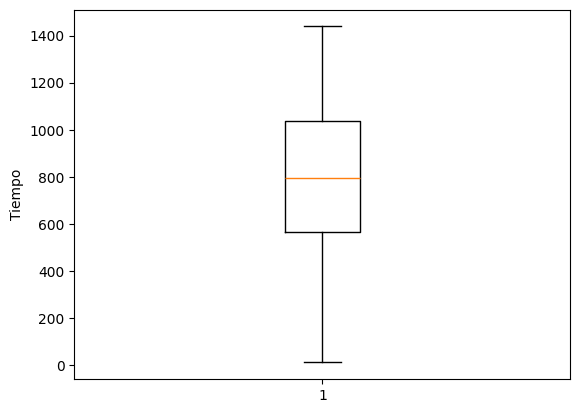

In [17]:
plt.boxplot(pandas_df['Time'])

# Agregar etiqueta al eje y
plt.ylabel('Tiempo')

# Mostrar la gráfica
plt.show()

In [18]:
for col in df_new.columns:
    print(f"{col} {df_new.filter(df_new[col].isNull()).count()}" )

Airline 0
Flight 0
AirportFrom 0
AirportTo 0
DayOfWeek 0
Time 0
Length 0
Delay 0
Length Scaled 0


In [19]:
distinct_counts = {var: df_new.select('AirportTo').distinct().count() for var in df_new.columns}

In [20]:
for var, count in distinct_counts.items():
    print(f"Variable '{var}' tiene {count} valores distintos.")


Variable 'Airline' tiene 293 valores distintos.
Variable 'Flight' tiene 293 valores distintos.
Variable 'AirportFrom' tiene 293 valores distintos.
Variable 'AirportTo' tiene 293 valores distintos.
Variable 'DayOfWeek' tiene 293 valores distintos.
Variable 'Time' tiene 293 valores distintos.
Variable 'Length' tiene 293 valores distintos.
Variable 'Delay' tiene 293 valores distintos.
Variable 'Length Scaled' tiene 293 valores distintos.


In [21]:
from pyspark.ml.feature import StringIndexer

columns_to_index = ["Airline","AirportFrom","AirportTo"]

indexer = StringIndexer(inputCols = columns_to_index, outputCols = ["Airline_index","AirportFrom_index","AirportTo_index"])

model = indexer.fit(df_new)
df_indexed = model.transform(df_new)

df_indexed.show(10)

+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|      Length Scaled|Airline_index|AirportFrom_index|AirportTo_index|
+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+
|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|0.31297709923664124|          9.0|              9.0|            5.0|
|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|0.33893129770992364|          5.0|              6.0|           10.0|
|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|0.25190839694656486|          3.0|              4.0|            2.0|
|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|0.29770992366412213|          3.0|              9.0|            2.0|
|     AS|   108|        ANC|      SEA|        3|  30|  

In [22]:
from pyspark.ml.feature import OneHotEncoder

# Aplicar OneHotEncoder a la variable indexada
encoder = OneHotEncoder(inputCols = ["Airline_index"], outputCols = ["Airline_onehot"], dropLast=False)
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

df_encoded.show(10)

+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+---------------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|      Length Scaled|Airline_index|AirportFrom_index|AirportTo_index| Airline_onehot|
+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+---------------+
|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|0.31297709923664124|          9.0|              9.0|            5.0| (18,[9],[1.0])|
|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|0.33893129770992364|          5.0|              6.0|           10.0| (18,[5],[1.0])|
|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|0.25190839694656486|          3.0|              4.0|            2.0| (18,[3],[1.0])|
|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|0.29770992366412213|        

In [24]:
from pyspark.ml.feature import VectorAssembler

columns_to_normalize = ['Flight', 'DayOfWeek','Time','Length','Delay',
                        'Length Scaled','Airline_index','AirportFrom_index','AirportTo_index',
                        'Airline_onehot']

assembler = VectorAssembler(inputCols = columns_to_normalize, outputCol = "features")

df_vector = assembler.transform(df_encoded)

df_vector.show(10)

+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+---------------+--------------------+
|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|      Length Scaled|Airline_index|AirportFrom_index|AirportTo_index| Airline_onehot|            features|
+-------+------+-----------+---------+---------+----+------+-----+-------------------+-------------+-----------------+---------------+---------------+--------------------+
|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|0.31297709923664124|          9.0|              9.0|            5.0| (18,[9],[1.0])|(27,[0,1,2,3,4,5,...|
|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|0.33893129770992364|          5.0|              6.0|           10.0| (18,[5],[1.0])|(27,[0,1,2,3,4,5,...|
|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|0.25190839694656486|          3.0|              4.0|            2.0| (18,[